In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model

from nicks_plot_utils import *

import inspect

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

In [3]:
golden_df = pd.read_csv("/Users/tylern/Data/e1d/gr.csv")
print(len(golden_df))
#golden_df = golden_df.groupby(golden_df['run_num'], as_index=False).aggregate({'run_num': 'first', 'num_elec': 'sum', 'num_of_events': 'sum', 'total_q': 'sum'})
golden_df['ratio'] = golden_df['num_elec'] / golden_df['total_q']
# golden_df['ratio'] = golden_df['_ratio']
golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
# golden_df = golden_df.sort_values(by=['run_num']).reset_index()
# golden_df['sum_q'] = np.cumsum(golden_df['total_q'])

golden_df.head()

2277


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run
0,0,22848,0,11031,118557,2.623000,45199.011719,4205.490047,228480
1,1,22848,11,8199,87643,29.356300,2985.491943,279.292687,228491
2,2,22853,0,11693,122596,2.773400,44204.230469,4216.124871,228530
3,3,22853,1,11708,122954,2.870000,42841.109375,4079.441994,228531
4,4,22853,2,12081,122566,2.886099,42467.707031,4185.927295,228532


In [4]:
run_list = pd.read_csv("/Users/tylern/Data/e1d/out.csv").rename(columns={"Run Id": "run_num"})
run_list['Number of Events'] = pd.to_numeric(run_list['Number of Events'], errors='coerce')
run_list.head()

,run_num,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22678,2000-01-31 10:16:00.0,1645.03,0.0,0.977,0,27380.0,e_calib_misc,56Fe
1,22679,2000-01-31 10:29:00.0,1645.03,0.0,0.977,0,32546.0,e_calib_misc,56Fe
2,22680,2000-01-31 10:35:00.0,1645.03,0.0,0.977,0,555588.0,e_calib_misc,56Fe
3,22681,2000-01-31 14:47:00.0,1645.03,0.0,-0.977,0,980.0,e_calib_misc,other
4,22682,2000-01-31 14:52:00.0,1645.03,0.0,0.977,0,1133.0,e_calib_misc,other


In [5]:
golden = pd.merge(golden_df, run_list, on='run_num')
#golden = golden_df
empty = golden[golden.Target == "empty"]
golden = golden[(golden.Target == "H2_full") & (golden["Run Type"] == 'beam_electron')]
golden.dropna(inplace=True)
print(len(golden))
golden.head(10)

2274


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,22848,0,11031,118557,2.623000,45199.011719,4205.490047,228480,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
1,1,22848,11,8199,87643,29.356300,2985.491943,279.292687,228491,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
2,2,22853,0,11693,122596,2.773400,44204.230469,4216.124871,228530,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
3,3,22853,1,11708,122954,2.870000,42841.109375,4079.441994,228531,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
4,4,22853,2,12081,122566,2.886099,42467.707031,4185.927295,228532,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
5,5,22853,3,12008,124287,2.898301,42882.707031,4143.116772,228533,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
6,6,22853,4,12067,124488,2.920600,42624.121094,4131.685359,228534,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
7,7,22853,5,11930,124018,2.868100,43240.468750,4159.547892,228535,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
8,8,22853,6,11982,123500,2.914000,42381.613281,4111.874338,228536,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
9,9,22853,7,11921,122935,2.828001,43470.636719,4215.345011,228537,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full


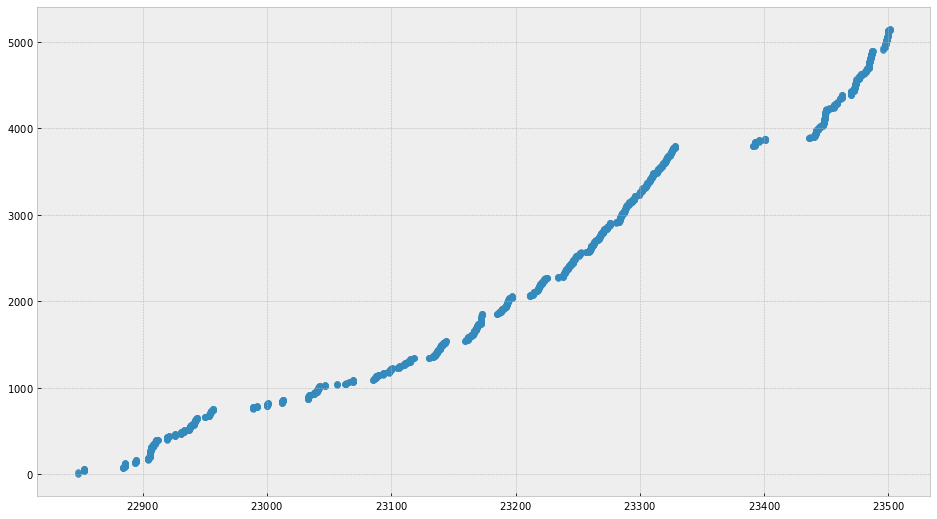

In [6]:
plt.scatter(golden['run_num'], np.cumsum(golden['total_q']), alpha=0.9);

Parameters([('amplitude', <Parameter 'amplitude', value=114910.51555208967 +/- 2.94e+03, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=5073.2755706556745 +/- 4.42, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=149.67507575570505 +/- 4.42, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=352.4578618910494 +/- 10.4, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=306.28122375805157 +/- 7.84, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])


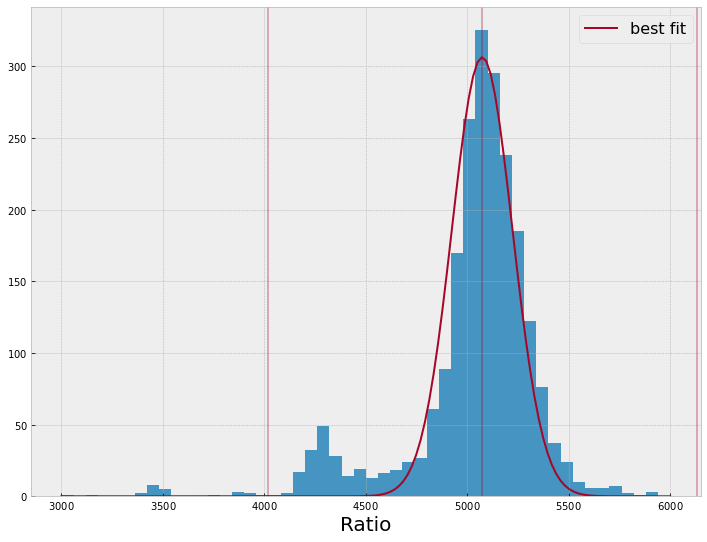

In [7]:
SIGMA = 3
fig = plt.figure(figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden['ratio'], bins=50, histtype='stepfilled', alpha=0.9, range=[3_000, 6_000])

x = bin_borders[:-1]
y = bin_heights

mod = GaussianModel()
pars = mod.guess(y, x=x)
pars['center'].set(value=6_000)
out = mod.fit(y, pars, x=x)

xs=np.linspace(3_000, 6_000, 140)

plt.plot(xs, out.eval(x=xs), COLOR_RED, label='best fit')

center = out.params['center'].value
fwhm = out.params['fwhm'].value

print(out.params)

plt.axvline(x=center, c=COLOR_RED, alpha=0.3)
plt.axvline(x=center+SIGMA*fwhm, c=COLOR_RED, alpha=0.3)
plt.axvline(x=center-SIGMA*fwhm, c=COLOR_RED, alpha=0.3)

#plt.ylim(0)
plt.xlabel('Ratio')
plt.legend()
plt.show()

5073.2755706556745


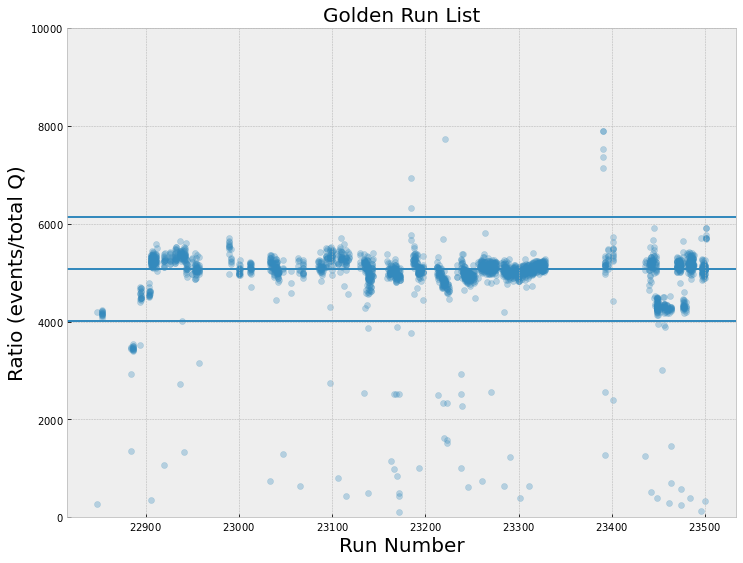

In [8]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden['run_num'], golden['ratio'], alpha=0.3)
print(center)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 10_000])
plt.show()


In [9]:
# runs = golden[(golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)].run_num
# cut_out = golden[~golden.run_num.isin(runs.values)]
# after_cut = golden[golden.run_num.isin(runs.values)]

runs = (golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)
cut_out = golden[~runs]
after_cut = golden[runs]


print(len(after_cut))
after_cut.head()

2180


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,22848,0,11031,118557,2.623000,45199.011719,4205.490047,228480,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
2,2,22853,0,11693,122596,2.773400,44204.230469,4216.124871,228530,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
3,3,22853,1,11708,122954,2.870000,42841.109375,4079.441994,228531,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
4,4,22853,2,12081,122566,2.886099,42467.707031,4185.927295,228532,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
5,5,22853,3,12008,124287,2.898301,42882.707031,4143.116772,228533,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full


In [ ]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.scatter(cut_out['run_num'], cut_out['ratio'], alpha=0.5)
plt.scatter(empty['run_num'], empty['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden File List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 10_000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden.index, np.cumsum(golden['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()
plt.show()


print(Q_tot := np.max(np.cumsum(after_cut.total_q)))
#print(Q_tot := np.max(np.cumsum(golden.total_q)))




In [ ]:
def luminosity(Q_tot=3000):
    # Q_tot = 15623.89E-6  # mC E-6 -> C
    Q_tot *= 1E-6
    # Q_tot = 2906.9858369E-6 # 2nd attempt
    # Q_tot = 2742.5087E-6 # 1st attempt
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39  # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30  # From wolfram alpha

    # * conv_cm2_to_fm2
    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [ ]:
print(f'{Q_tot:0.5f}')
print(f'{luminosity(Q_tot=Q_tot):0.5e}')
print(f'{luminosity():0.5e}')

In [ ]:
for index, run in after_cut.iterrows():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run.run_num}_{run.file_num:02d}.root golden_run/;"
    # print(command)
    #x = os.system(command)
    # print(command)
    

In [ ]:
from shutil import copyfile
for index, run in after_cut.iterrows():
    # command = f"cp /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run.run_num}_{run.file_num:02d}.root /Users/tylern/Data/e1d/golden_run_2/;"
    src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run.run_num}_{run.file_num:02d}.root'
    dst = f'/Users/tylern/Data/e1d/golden_run_2/h10_r{run.run_num}_{run.file_num:02d}.root'
    #os.system(command)
#     print(f"h10_r{run.run_num}_{run.file_num:02d}.root")
#     copyfile(src, dst)

    

In [ ]:
np.sum(after_cut.num_elec)/np.sum(golden.num_elec)

In [ ]:
len(after_cut)/len(golden)